## Abstract

**Microscopy Hackathons December 16 and 17 2024**


**Project Goal**:
 - Map the phase regions with your choice of unsupervised algorithm (sliding FFT, rVAE, other).  Learn about the phases structures as well as the different combinations of interfaces.
 - Physics based workflow

**Dataset**:
- Atomic resolution dataset of 2D polycrystalline Pd-Se phases
- by Austin Houston: University of Tennesse Knoxville

**Group members**:
- Kamyar Barakati: University of Tennesse Knoxville
- Aditya Raghavan: University of Tennesse Knoxville

## Data preparation

Upload dataset

In [ ]:
! gdown --fuzzy --id 1TFLNm2EtMsY7Af69TrxTzoOxotuJ5OJf

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1TFLNm2EtMsY7Af69TrxTzoOxotuJ5OJf
From (redirected): https://drive.google.com/uc?id=1TFLNm2EtMsY7Af69TrxTzoOxotuJ5OJf&confirm=t&uuid=f4af88c0-5d47-44a3-b448-116e489dc5b4
To: /content/PdSe_images-20241216T165954Z-001.zip
100% 213M/213M [00:05<00:00, 37.6MB/s]


In [ ]:
!unzip /content/PdSe_images-20241216T165954Z-001.zip

Archive:  /content/PdSe_images-20241216T165954Z-001.zip
  inflating: PdSe_images/image_26.npz  
  inflating: PdSe_images/image_27.npz  
  inflating: PdSe_images/image_44.npz  
  inflating: PdSe_images/image_20.npz  
  inflating: PdSe_images/image_63.npz  
  inflating: PdSe_images/image_61.npz  
  inflating: PdSe_images/image_25.npz  
  inflating: PdSe_images/image_18.npz  
  inflating: PdSe_images/image_3.npz  
  inflating: PdSe_images/image_83.npz  
  inflating: PdSe_images/image_6.npz  
  inflating: PdSe_images/image_58.npz  
  inflating: PdSe_images/image_75.npz  
  inflating: PdSe_images/image_64.npz  
  inflating: PdSe_images/image_51.npz  
  inflating: PdSe_images/image_5.npz  
  inflating: PdSe_images/image_29.npz  
  inflating: PdSe_images/image_28.npz  
  inflating: PdSe_images/image_12.npz  
  inflating: PdSe_images/image_59.npz  
  inflating: PdSe_images/image_36.npz  
  inflating: PdSe_images/image_38.npz  
  inflating: PdSe_images/image_2.npz  
  inflating: PdSe_images/ima

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.transform import resize
from collections import defaultdict
from scipy.fftpack import fft2, ifft2, fftshift
from sklearn.decomposition import NMF

In [ ]:
# Path to the folder containing the images
folder_path = '/content/PdSe_images'

# Dictionary to store images and pixel sizes: {file_number: {'image': array, 'pixel_size': value}}
image_dict = {}

# Step 1: Collect and sort file names in numerical order
file_list = [f for f in os.listdir(folder_path) if f.endswith('.npz')]

# Sort files based on the numerical part of the file name
sorted_files = sorted(file_list, key=lambda x: int(x.split('_')[1].split('.')[0]))

# Step 2: Load images and pixel sizes and store in the dictionary
for file_name in sorted_files:
    file_path = os.path.join(folder_path, file_name)
    try:
        # Load the .npz file
        data = np.load(file_path)

        # Extract image data and pixel size
        if 'image' in data and 'pixel_size' in data:
            image = data['image']
            pixel_size = data['pixel_size']

            # Ensure pixel size is scalar
            if isinstance(pixel_size, np.ndarray):
                pixel_size = pixel_size.item()

            # Use file number as key
            file_number = int(file_name.split('_')[1].split('.')[0])
            image_dict[file_number] = {'image': image, 'pixel_size': pixel_size}
        else:
            print(f"'image' or 'pixel_size' key missing in {file_name}")
    except Exception as e:
        print(f"Error loading {file_name}: {e}")

# Step 3: Display a summary of the loaded data
print(f"Loaded {len(image_dict)} files into the dictionary.")
for k, v in image_dict.items():
    print(f"Image {k}: shape {v['image'].shape}, pixel size {v['pixel_size']}")

Loaded 81 files into the dictionary.
Image 1: shape (1024, 1024), pixel size 0.03125
Image 2: shape (1024, 1024), pixel size 0.03125
Image 3: shape (1024, 1024), pixel size 0.015625
Image 4: shape (1024, 1024), pixel size 0.03125
Image 5: shape (1024, 1024), pixel size 0.03125
Image 6: shape (1024, 1024), pixel size 0.03125
Image 7: shape (1024, 1024), pixel size 0.03125
Image 8: shape (1024, 1024), pixel size 0.03125
Image 9: shape (1024, 1024), pixel size 0.03125
Image 10: shape (1024, 1024), pixel size 0.03125
Image 12: shape (1024, 1024), pixel size 0.03125
Image 14: shape (1024, 1024), pixel size 0.03125
Image 16: shape (1024, 1024), pixel size 0.03125
Image 17: shape (2048, 2048), pixel size 0.015625
Image 18: shape (1024, 1024), pixel size 0.125
Image 19: shape (1024, 1024), pixel size 0.015625
Image 20: shape (1024, 1024), pixel size 0.015625
Image 21: shape (1024, 1024), pixel size 0.03125
Image 22: shape (1024, 1024), pixel size 0.03125
Image 23: shape (1024, 1024), pixel siz

In [ ]:
# Dictionary to group image indices by pixel size
grouped_by_pixel_size = defaultdict(list)

# Step 1: Iterate through the image_dict and group indices by pixel size
for idx, data in image_dict.items():
    pixel_size = data['pixel_size']
    grouped_by_pixel_size[pixel_size].append(idx)

# Step 2: Display the grouped results
print("Grouped Image Indices by Pixel Size:")
for pixel_size, indices in grouped_by_pixel_size.items():
    print(f"Pixel Size: {pixel_size}, Image Indices: {indices}")

Grouped Image Indices by Pixel Size:
Pixel Size: 0.03125, Image Indices: [1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 21, 22, 23, 25, 26, 29, 30, 32, 34, 35, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 53, 59, 60, 61, 62, 63, 64, 66, 71, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84]
Pixel Size: 0.015625, Image Indices: [3, 17, 19, 20, 27, 28, 31, 33, 37, 38, 54, 55, 56, 65, 67, 68, 69, 70, 78]
Pixel Size: 0.125, Image Indices: [18, 36, 46]
Pixel Size: 0.0625, Image Indices: [24, 45, 51, 72]
Pixel Size: 0.25, Image Indices: [52, 57, 58]


Select the image

In [ ]:
image_index = 30
if image_index in image_dict:
    image = image_dict[image_index]['image']

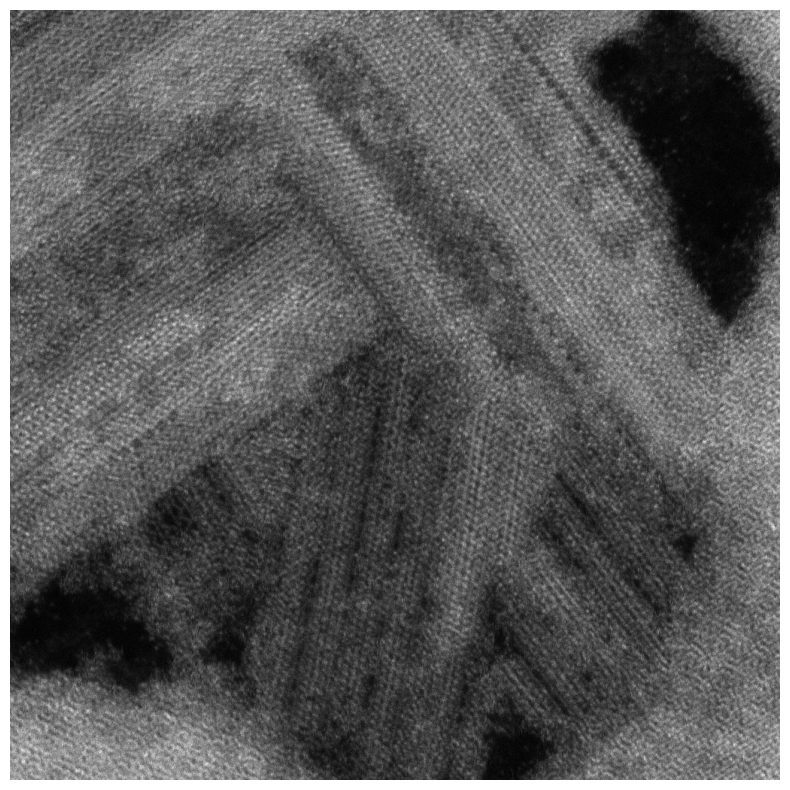

In [ ]:
# Display the first image
fig = plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')
# plt.title("Selected Image")
plt.axis("off")
plt.show()

Sliding transfom using different
1. window_size, and
2. step_size

In [ ]:
def custom_subimages(imgdata, step_size, window_size):
    # Generate coordinates based on step size
    height, width = imgdata.shape[:2]
    x_coords = np.arange(0, height - window_size[0] + 1, step_size)
    y_coords = np.arange(0, width - window_size[1] + 1, step_size)
    coordinates = [(x, y) for x in x_coords for y in y_coords]

    # Extract subimages of the specified window size
    half_height = window_size[0] // 2
    half_width = window_size[1] // 2
    subimages_target = []
    coms_target = []
    removed_due_to_size = 0
    removed_due_to_nans = 0

    for coord in coordinates:
        cx, cy = coord
        top = max(cx - half_height, 0)
        bottom = min(cx + half_height, height)
        left = max(cy - half_width, 0)
        right = min(cy + half_width, width)

        subimage = imgdata[top:bottom, left:right]

        if subimage.shape != tuple(window_size):
            removed_due_to_size += 1
        elif np.isnan(subimage).any():
            removed_due_to_nans += 1
        else:
            subimages_target.append(subimage)
            coms_target.append(coord)

    print("Number of subimages removed due to size mismatch:", removed_due_to_size)
    print("Number of subimages removed due to NaNs:", removed_due_to_nans)

    return np.array(subimages_target), np.array(coms_target)

TEST

In [ ]:
window_size = (16, 16)
step_size = 8

imstack_grid, com_grid = custom_subimages(image, step_size, window_size)

print(imstack_grid.shape)
print(com_grid.shape)

Number of subimages removed due to size mismatch: 253
Number of subimages removed due to NaNs: 0
(15876, 16, 16)
(15876, 2)


## Phase mapping

Sparsse linear unmixing

In [ ]:
def apply_fft(image_stack):

    fft_magnitudes = []
    for img in image_stack:
        fft_result = fft2(img)
        fft_magnitude = np.abs(fftshift(fft_result))
        fft_magnitudes.append(fft_magnitude)
    return np.array(fft_magnitudes)

def percentile_sparsity(pca_components, percentile):

    threshold = np.percentile(np.abs(pca_components), 100 - percentile)
    sparse_components = np.where(np.abs(pca_components) < threshold, 0, pca_components)
    return sparse_components

def apply_nmf(fft_magnitudes, n_components=5):
    reshaped_fft = fft_magnitudes.reshape(fft_magnitudes.shape[0], -1)
    nmf = NMF(n_components=n_components, init='random', random_state=42, max_iter=300)
    W = nmf.fit_transform(reshaped_fft)
    H = nmf.components_
    return W, H, nmf

# Function to reconstruct and reshape NMF components
def reconstruct_nmf_components(H, target_shape):
    components = []
    for i in range(H.shape[0]):
        component = H[i, :].reshape(target_shape)
        components.append(component)
    return np.array(components)

Test the algorithm

In [ ]:
window_size = (40, 40)
step_size = 2

imstack_grid, com_grid = custom_subimages(image, step_size, window_size)
fft_magnitudes = apply_fft(imstack_grid)

target_shape = window_size
n_components = 2

W, H, nmf = apply_nmf(fft_magnitudes, n_components= n_components)
nmf_components = reconstruct_nmf_components(H, target_shape)

print("NMF Components Shape:", nmf_components.shape)
print(W.shape)

Number of subimages removed due to size mismatch: 9760
Number of subimages removed due to NaNs: 0


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1741: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


NMF Components Shape: (2, 40, 40)
(233289, 2)


percentile_sparsity

In [ ]:
sparse_components_p = percentile_sparsity(W, percentile=90)
print("Number of Non-Zero Values:", np.count_nonzero(sparse_components_p))
print("Sparse Components Shape:", sparse_components_p.shape)

Number of Non-Zero Values: 419920
Sparse Components Shape: (233289, 2)


TEST Results

<ipython-input-14-1223830b6567>:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


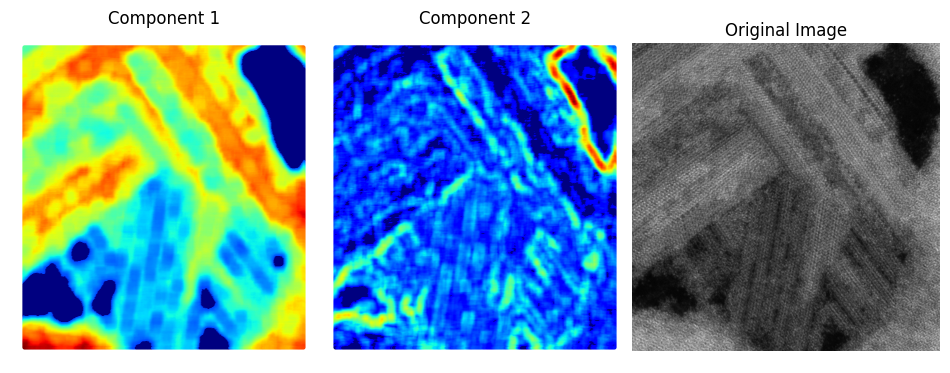

In [ ]:
n_components = sparse_components_p.shape[1]
n_cols = n_components + 1

fig, axes = plt.subplots(1, n_cols, figsize=(4 * n_cols, 4.3), gridspec_kw={"wspace": 0.01})
axes = np.ravel(axes)


for i in range(n_components):
    axes[i].scatter(com_grid[:, 1], com_grid[:, 0], c=sparse_components_p[:, i], cmap="jet", s=1)
    axes[i].invert_yaxis()
    axes[i].axis("off")
    axes[i].set_title(f"Component {i+1}", fontsize=12)


axes[-1].imshow(image, cmap="gray")
axes[-1].axis("off")
axes[-1].set_title("Original Image", fontsize=12)

plt.tight_layout()
plt.show()

Reconstruction

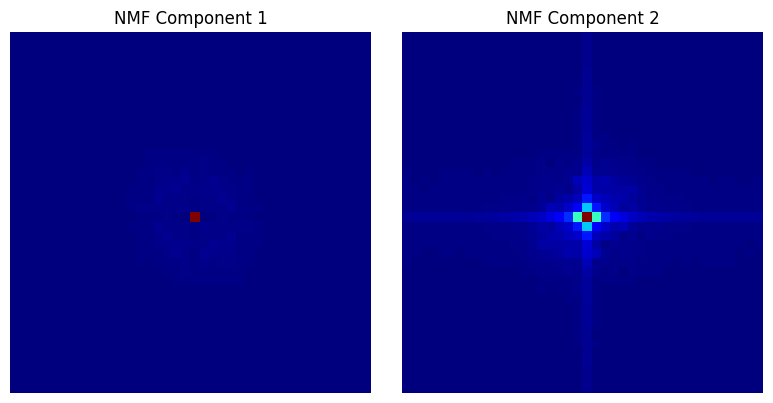

In [ ]:
def plot_nmf_components(nmf_components, n_rows=1, n_cols=None, cmap="jet"):

    n_components = nmf_components.shape[0]

    # Automatically calculate the number of columns if not provided
    if n_cols is None:
        n_cols = n_components

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

    # Flatten axes for iteration (works for any grid shape)
    axes = axes.flatten()

    for i in range(n_components):
        ax = axes[i]
        ax.imshow(nmf_components[i], cmap=cmap)
        ax.set_title(f"NMF Component {i+1}", fontsize=12)
        ax.axis("off")

    # Hide unused axes (if any)
    for j in range(n_components, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


# Example Usage
plot_nmf_components(nmf_components, n_rows=1, n_cols=nmf_components.shape[0], cmap="jet")

## Optimization_workflow_1

In [ ]:
! pip install GPyOpt
! pip install platypus-opt
! pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 10.5 MB/s eta 0:00:00
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83602 sha256=b98d7960a952982d271eaba2a23172d3213c7da7bdc481b296ff0ca6741d42fe
  Stored in directory: /root/.cache/pip/wheels/72/17/52/9d818b4c60f733bf49d5cf82bc2758ebbdc57a0471137c37be
Successfully built GPyOpt
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.

In [ ]:
from skimage.util import view_as_blocks
from skimage.measure import shannon_entropy
from skimage.morphology import disk
from sklearn.metrics import silhouette_score
from scipy.ndimage import label
from IPython.display import clear_output

In [ ]:
from platypus import Problem, Real, Integer, NSGAII, GAOperator, SBX, PM
import ipywidgets as widgets
import time

In [ ]:
def apply_fft(image_stack):

    fft_magnitudes = []
    for img in image_stack:
        fft_result = fft2(img)
        fft_magnitude = np.abs(fftshift(fft_result))
        fft_magnitudes.append(fft_magnitude)
    return np.array(fft_magnitudes)

def apply_nmf(fft_magnitudes, n_components=5):
    reshaped_fft = fft_magnitudes.reshape(fft_magnitudes.shape[0], -1)  # Flatten FFT data
    nmf = NMF(n_components=n_components, init='random', random_state=42, max_iter=300)
    W = nmf.fit_transform(reshaped_fft)  # Coefficients
    H = nmf.components_
    return W, H, nmf

def percentile_sparsity(pca_components, percentile):

    threshold = np.percentile(np.abs(pca_components), 100 - percentile)
    sparse_components = np.where(np.abs(pca_components) < threshold, 0, pca_components)
    return sparse_components

# Function to reconstruct and reshape NMF components
def reconstruct_nmf_components(H, target_shape):
    components = []
    for i in range(H.shape[0]):
        component = H[i, :].reshape(target_shape)
        components.append(component)
    return np.array(components)

**Define rewards:**

- They should have physical meaning meaning with respect to the experiment puposes

In [ ]:
def reward_1(sparse_components_p, grid_shape):

    reward = 0
    threshold=0.01
    n_components = sparse_components_p.shape[1]

    for i in range(n_components):
        component = sparse_components_p[:, i]  # Extract one component
        mask = component > threshold  # Create a binary mask for significant values

        # Reshape mask to match the original grid shape
        mask_reshaped = mask.reshape(grid_shape)

        # Label connected regions
        labeled_array, num_features = label(mask_reshaped)

        # Compactness: fewer, larger connected regions increase the reward
        if num_features > 0:
            reward += 1 / num_features  # Inverse of number of regions

    return reward / n_components  # Average reward across components


def reward_2(sparse_components_p):

    n_comp_1 = sparse_components_p.shape[1]

    # Normalize each sparse component
    normalized_components = sparse_components_p / (np.linalg.norm(sparse_components_p, axis=0) + 1e-10)

    # Calculate pairwise dot products (cosine similarity)
    dot_product_matrix = np.abs(np.dot(normalized_components.T, normalized_components))
    np.fill_diagonal(dot_product_matrix, 0)  # Ignore self-similarity

    # Phase separation reward: minimize overlap (dot product between components)
    separation_reward = 1 - np.max(dot_product_matrix)

    return separation_reward

Define the parameter space of the experiment:

1. window_size hight
2. window_size width
3. Sparse unmixing percentage

So our optimization space has **2** rewards and **3** hyperparameters

In [ ]:
class MyOptimizationProblem(Problem):
    def __init__(self):
        super(MyOptimizationProblem, self).__init__(3, 2)
        self.types[:] = [
            Real(4, 60),
            Real(4, 60),
            Real(1, 99),
        ]
        self.directions[:] = [Problem.MINIMIZE, Problem.MINIMIZE]

    def evaluate(self, solution):
        def to_even_value(x):
            return int(np.round(x / 2) * 2)

        win_size = (to_even_value(solution.variables[0]), to_even_value(solution.variables[1]))
        sparse_per = int(solution.variables[2])

        # workflow
        step_size = 2
        n_components = 2

        imstack_grid, com_grid = custom_subimages(image, step_size, win_size)
        fft_magnitudes = apply_fft(imstack_grid)

        target_shape = win_size
        W, H, nmf = apply_nmf(fft_magnitudes, n_components)
        nmf_components = reconstruct_nmf_components(H, target_shape)

        sparse_components_p = percentile_sparsity(W, sparse_per)

        grid_shape = (len(np.unique(com_grid[:, 0])), len(np.unique(com_grid[:, 1])))

        rdw_1 = reward_1(sparse_components_p, grid_shape)
        rdw_2 = reward_2(sparse_components_p)

        solution.objectives[:] = [rdw_1, rdw_2]

In [ ]:
# Instantiate the problem
problem = MyOptimizationProblem()

start_time = time.time()

# Solve the problem using NSGA-II
algorithm = NSGAII(problem, population_size = 20)
algorithm.run(2)

# End timing
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Print results
for solution in algorithm.result:
    print(f"Objectives: {solution.objectives}, Parameters: {solution.variables}")

print(f"Time taken: {elapsed_time:.2f} seconds")

Number of subimages removed due to size mismatch: 4037
Number of subimages removed due to NaNs: 0


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1741: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


Number of subimages removed due to size mismatch: 6477
Number of subimages removed due to NaNs: 0


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1741: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


Number of subimages removed due to size mismatch: 11616
Number of subimages removed due to NaNs: 0


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1741: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


**Pareto-Front Solutions with human involved in decision making**

- Meaning with parameters to use with regard to the purpose of the experiment

In [ ]:
solutions = algorithm.result
objectives = [s.objectives[:] for s in solutions]

obj1 = [o[0] for o in objectives]  # First objective
obj2 = [o[1] for o in objectives]  # Second objective

slider = widgets.IntSlider(min=0, max=len(solutions) - 1, step=1, description='Solution Index:')

# Create output widget to display the hyperparameters and rewards
output = widgets.Output()

def update_plot(change):
    with output:
        clear_output(wait=True)
        index = change['new']
        solution = solutions[index]
        print(f"Hyperparameters: {solution.variables}")
        print(f"Reward 1: {solution.objectives[0]}")
        print(f"Reward 2: {solution.objectives[1]}")

        # Redraw the plot with the selected point highlighted in red
        plt.scatter(obj1, obj2, s=20, marker='o', c="blue", alpha=0.5)
        plt.scatter(obj1[index], obj2[index], s=50, marker='*', c="red")
        plt.xlabel('Objective 1')
        plt.ylabel('Objective 2')
        plt.title('Pareto Front')
        plt.xlim(-0.1, 1.1)
        plt.ylim(-0.1, 1.1)
        plt.grid(True)
        plt.show()

# Observe changes to the slider value and trigger the update function
slider.observe(update_plot, names='value')

# Display the slider and output widgets
display(slider, output)

# Initial plot (now with the first solution highlighted in red)
update_plot({'new': 0})

**TEST**

In [ ]:
# Hyperparameters: [10.315810573847578, 19.232044248267798, 57.94823570731644]
# round the hyperparameters

# Step 1: Extract subimages
window_size = (8, 22)
sparse_percentage = 98
step_size = 2
imstack_grid, com_grid = custom_subimages(image, step_size, window_size)

# Step 2: Apply FFT on subimages
fft_magnitudes = apply_fft(imstack_grid)

# Step 3: Apply NMF on FFT data
target_shape = window_size
W, H, nmf = apply_nmf(fft_magnitudes, n_components=2)
nmf_components = reconstruct_nmf_components(H, target_shape)

# Step 4: Introduce sparsity on NMF coefficients (W)
sparse_components_p = percentile_sparsity(W, percentile=sparse_percentage)

# Step 5: Reconstruct the data using sparse coefficients (optional)
reconstructed_sparse_fft = np.dot(sparse_components_p, H)

# Output
print("NMF Components Shape (H):", nmf_components.shape)
print("Sparse Coefficients Shape (W):", sparse_components_p.shape)
print("Number of Non-Zero Values in Sparse Coefficients:", np.count_nonzero(sparse_components_p))

In [ ]:
n_components = sparse_components_p.shape[1]
n_cols = n_components + 1

fig, axes = plt.subplots(1, n_cols, figsize=(4 * n_cols, 4.3), gridspec_kw={"wspace": 0.01})
axes = np.ravel(axes)


for i in range(n_components):
    axes[i].scatter(com_grid[:, 1], com_grid[:, 0], c=sparse_components_p[:, i], cmap="jet", s=1)
    axes[i].invert_yaxis()
    axes[i].axis("off")
    axes[i].set_title(f"Component {i+1}", fontsize=12)


axes[-1].imshow(image, cmap="gray")
axes[-1].axis("off")
axes[-1].set_title("Original Image", fontsize=12)

plt.tight_layout()
plt.show()

## ## Optimization_workflow_2

In [ ]:
def reward_3(error):

    epsilon = 1e-8  # Small value to avoid division by zero
    error_reward = np.mean(1 / (1 + error + epsilon))
    return error_reward